<a href="https://colab.research.google.com/github/gtbook/gtsam-examples/blob/main/KalmanSmootherExample2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Kalman Smoothing

Using multi-frontal elimination to solve a linear Markov chain yields a Bayes tree, which is a directed junction tree. This provides some powerful opportunities for parallelism on multi-core machines or even clusters.

In [101]:
%pip -q install gtbook # also installs latest gtsam pre-release

Note: you may need to restart the kernel to use updated packages.


In [102]:
import math
import matplotlib.pyplot as plt
import numpy as np

import gtsam
import gtsam.utils.plot as gtsam_plot
from gtbook.display import show
from gtbook.gaussian import sample_bayes_net
from gtsam import Point2, noiseModel

# Some keys we use below:
N = 10 # change this at will!
x = [gtsam.symbol('x', i) for i in range(N)]

## A Larger Kalman Smoother Example

 let's create a larger call Kalman smoothing example, using $N$ from the preamble above:

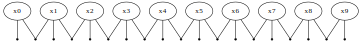

In [103]:
gfg = gtsam.GaussianFactorGraph()

# add "measurements" |x1|^2, |x2-(2,0)|^2, ...
model2 = noiseModel.Isotropic.Sigma(2, 0.5)
I2 = np.eye(2, dtype=float)
for i, key in enumerate(x):
    gfg.add(gtsam.JacobianFactor(i1=key, A1=I2,
            b=gtsam.Point2(i*2, 0), model=model2))  # prior

# add "motion models" |x2 - x1 - (2,0)|^2, ...
motion_model = noiseModel.Diagonal.Sigmas([0.2,0.9])
for i1, i2 in zip(x[:-1],x[1:]):
    gfg.add(gtsam.JacobianFactor(i1=i1, A1=-I2, i2=i2, A2=I2,
            b=gtsam.Point2(2, 0), model=motion_model))  # between x1 and x2

show(gfg)


## The "default" Bayes Tree

The default "forward" elimination ordering will eliminate $x_0$ first, then $x_1$, and so on, and the Bayes tree will be  a *chain* of cliques, as shown below. The root clique will contain the last *two* (multivariate) variables to be eliminated, and every subsequent clique is just a conditional. We call this "conditioning on past on the future".

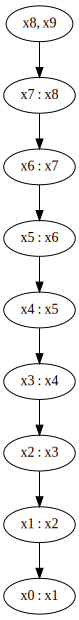

In [104]:
forward_bayes_tree = gfg.eliminateMultifrontal()
show(forward_bayes_tree)

## The "Backwards" Bayes Tree

By specifying the elimination order in reverse, we get a BayesTree where the future is condition on the past instead:

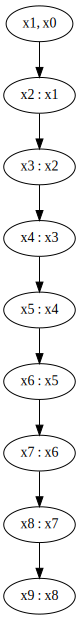

In [105]:
backward = gtsam.Ordering()
for key in reversed(x): backward.push_back(key)
backward_bayes_tree = gfg.eliminateMultifrontal(backward)
show(backward_bayes_tree)

## Burning at Both Ends

These two orderings, forward and backward, are nice because the elimination happens in $O(N)$, as each elimination step (except the root) factorizes exactly the same matrix size. Could we make things operate in parallel by providing an ordering that eliminates both sides in parallel? The answer is yes:

Position 0: x0, x1, x2, x3, x4, x9, x8, x7, x6, x5

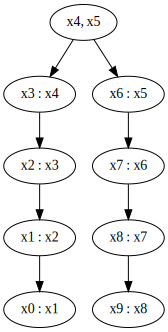

In [106]:
middle_out = gtsam.Ordering()  # Pied piper!
for key in x[:N//2]: middle_out.push_back(key)
for key in reversed(x[N//2:]): middle_out.push_back(key)
display(middle_out)
middle_out_bayes_tree = gfg.eliminateMultifrontal(middle_out)
show(middle_out_bayes_tree)

Now, on a multi-core CPU or cluster both branches of the Bayes tree can be computed simultaneously.

## Nested Dissection

A generalization of this scheme is to do the same trick in both branches. This is called "nested dissection" and is implemented in GTSAM for general graphs by [Metis](http://glaros.dtc.umn.edu/gkhome/metis/metis/overview).

Position 0: x0, x2, x3, x1, x9, x7, x6, x8, x4, x5

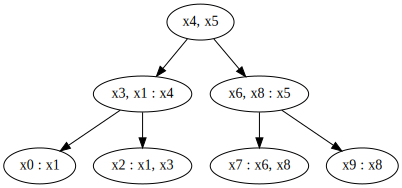

In [107]:
if N==10:
    nested = gtsam.Ordering()
    for i in [0,2,3, 1, 9,7,6, 8, 4,5]: nested.push_back(x[i])
else:
    nested = gtsam.Ordering.MetisGaussianFactorGraph(gfg)
display(nested)
nested_bayes_tree = gfg.eliminateMultifrontal(nested)
show(nested_bayes_tree)

This Bayes tree exactly captures the clique structure of the Bayes net, which we can also visualize:

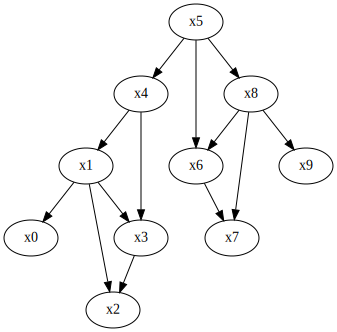

In [108]:
gbn = gfg.eliminateSequential(nested)
show(gbn)

And of course, now ancestral sampling can also be done in parallel (here in the Bayes net):

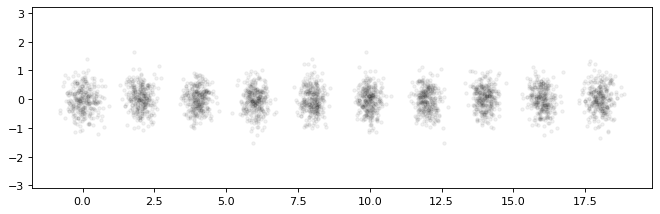

In [112]:
plt.figure(0, figsize=(10, 3), dpi=80)
for key, points in sample_bayes_net(gbn, 300).items():
    plt.plot(points[0], points[1], 'k.', alpha=0.05)
plt.axis('equal');

## Ordering Matters!

The above orderings are very carefully chosen, and a package like Metis spends quite some compute to find a good way to recursively break up a general graph into smaller pieces. In contrast, if you were to use a *random* ordering, you should expect it to get very bad performance in solving these sparse linear systems. We demonstrate the mess below. Try this for larger $N$ :-).

In [159]:
rng = np.random.default_rng(4)
random = gtsam.Ordering()
for i in rng.choice(N, size=(N,), replace=False):
    random.push_back(x[i])
random

Position 0: x7, x1, x5, x0, x8, x9, x4, x3, x2, x6

The Bayes net is messy and unstructured, and contains several large cliques:

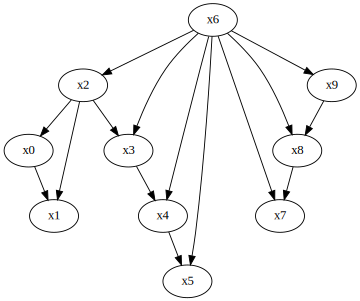

In [160]:
random_gbn = gfg.eliminateSequential(random)
show(random_gbn)

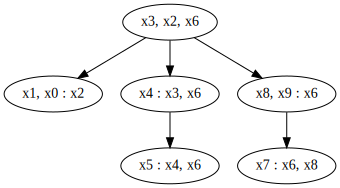

In [161]:
random_bayes_tree = gfg.eliminateMultifrontal(random)
show(random_bayes_tree)

## Conclusion

In conclusion, ordering matters! In large graphs, choosing a bad ordering could mean orders of magnitude slower compute.